In [12]:
import pandas as pd
import geopandas as gpd
import numpy as np
from housing_elements import utils, los_altos_permits, san_francisco_permits, san_jose_permits, map_utils
from pathlib import Path

In [2]:
from importlib import reload
reload(los_altos_permits)
reload(san_francisco_permits)
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
# Silence an annoying warning that I get when running pd.read_excel
import warnings
warnings.filterwarnings("ignore", message="Data Validation extension is not supported and will be removed")

# Load sites and permits DataFrames for each city

In [5]:
# Load this once, to speed up load_site_inventory below
sites_df = utils.load_all_sites()

In [6]:
all_cities = sites_df.jurisdict.unique()

In [7]:
# Load this once, to speed up load_all_new_building_permits below
abag_permits_df = utils.load_abag_permits()

In [8]:
%%time
cities_with_sites = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_sites[city] = utils.load_site_inventory(city, sites_df=sites_df)
            cities_with_sites[city].relcapcty.sum()
        except Exception:
            pass

CPU times: user 8.19 s, sys: 165 ms, total: 8.35 s
Wall time: 8.45 s


In [9]:
len(cities_with_sites)

108

In [10]:
%%time
cities_with_permits = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_permits[city] = utils.load_all_new_building_permits(city, abag_permits_df)
        except Exception:
            print(city, file=sys.stderr)

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
Contra Costa County
Alameda County
Corte Madera
Marin County
Saint Helena
Napa County
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
Hillsborough
San Mateo County
Sonoma County


CPU times: user 5min 50s, sys: 9.78 s, total: 6min
Wall time: 6min 20s


Solano County


# Output results to json files

In [31]:
reload(map_utils)
map_utils.write_matches_to_files(
    cities_with_sites,
    cities_with_permits,
    Path('./json_output')
)

100%|██████████| 108/108 [01:34<00:00,  1.14it/s]


In [34]:
sites_df.geometry.total_bounds

array([-123.1360271 ,   36.97640742, -121.53590925,   38.82979915])

# Misc

In [17]:
cities_with_permits['Oakland']['hcategory'].value_counts()

ADU       395
SF        374
5+        233
SU        204
SFD       128
2 to 4    102
SFA        14
MH          2
Name: hcategory, dtype: int64

In [26]:
abag_permits_df['hcategory'].value_counts()

SF              20640
5+               2453
SU               2374
2 to 4           1167
sf                276
Unidentified       52
MH                 42
COMM                2
su                  2
SF, 2 to 4          1
Name: hcategory, dtype: int64

In [19]:
oakland_df = pd.read_json('json_output/Oakland/permits.geojson')

In [21]:
oakland_df.iloc[0]['features']

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-122.232142469899, 37.8539934827131]},
 'properties': {'permit_year': 2017,
  'permit_address': '5 NORTH HILL CT',
  'permit_units': 1.0,
  'permit_category': 'SU'}}

# Make results tables

In [634]:
def get_results_for_city(city: str, match_by: str) -> pd.DataFrame:
    permits = cities_with_permits[city]
    
    sites = cities_with_sites[city]
    
    nonvacant_matches, nonvacant_sites, nonvacant_ratio = utils.calculate_pdev_for_nonvacant_sites(sites, permits, match_by)
    vacant_matches, vacant_sites, vacant_ratio = utils.calculate_pdev_for_vacant_sites(sites, permits, match_by)
    all_matches, all_sites, all_ratio = utils.calculate_pdev_for_inventory(sites, permits, match_by)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': nonvacant_ratio,
        'P(dev) for vacant sites': vacant_ratio,
        'P(dev) for inventory': all_ratio,
        '# nonvacant matches': f'{nonvacant_matches} / {nonvacant_sites}',
        '# vacant matches': f'{vacant_matches} / {vacant_sites}',
        '# matches': f'{all_matches} / {all_sites}',
    }

In [462]:
cities = [city for city in all_cities if city in cities_with_permits and city in cities_with_sites]

In [463]:
len(cities)

92

In [617]:
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [590]:
%%time
with HiddenPrints():
    results_df = pd.DataFrame([get_results_for_city(city, match_by='apn') for city in cities])

CPU times: user 6.89 s, sys: 379 ms, total: 7.27 s
Wall time: 7.59 s


In [635]:
results_df.round(3)

City  Ratio of development on inventory sites  \
0       Berkeley                                    0.348   
1         Albany                                    0.634   
2        Alameda                                    0.535   
3      Livermore                                    0.577   
4        Fremont                                    0.876   
..           ...                                      ...   
87     Rio Vista                                    0.102   
88  Monte Sereno                                    1.424   
89    Healdsburg                                    0.511   
90     Fairfield                                    0.320   
91        Sonoma                                    0.182   

    Mean overproduction  Inventory housing / all housing  \
0                 1.255                            0.041   
1                   NaN                            0.000   
2                   NaN                            0.000   
3                 1.238                            0.245   
4                 0.438                            0.112   
..                  ...                              ...   
87                  NaN                            0.000   
88                  NaN                            0.000   
89                0.279                            0.028   
90                0.300                            0.001   
91                0.103                            0.029   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
0                        0.012                    0.025                 0.020   
1                        0.000                    0.000                 0.000   
2                        0.000                    0.000                 0.000   
3                        0.071                    0.165                 0.119   
4                        0.028                    0.048                 0.031   
..                         ...                      ...                   ...   
87                         NaN                    0.000                 0.000   
88                       0.000                      NaN                 0.000   
89                       0.083                    0.083                 0.083   
90                       0.000                    0.026                 0.023   
91                       0.000                    0.200                 0.043   

   # nonvacant matches # vacant matches # matches  
0              2 / 167          6 / 237   8 / 404  
1               0 / 33            0 / 8    0 / 41  
2                0 / 7           0 / 11    0 / 18  
3               7 / 99         17 / 103  24 / 202  
4              4 / 141           1 / 21   5 / 162  
..                 ...              ...       ...  
87               0 / 0           0 / 23    0 / 23  
88               0 / 6            0 / 0     0 / 6  
89              2 / 24           3 / 36    5 / 60  
90               0 / 9           2 / 77    2 / 86  
91              0 / 18            1 / 5    1 / 23  

[92 rows x 10 columns]

In [638]:
results_df[
    results_df['P(dev) for inventory'] == 0
]

City  Ratio of development on inventory sites  \
1           Albany                                 0.633907   
2          Alameda                                 0.534967   
18         Antioch                                 0.394536   
24      Union City                                 0.432896   
25    Walnut Creek                                 0.992167   
26          Moraga                                 0.094317   
27        Hercules                                 0.271691   
28          Oakley                                 3.156098   
36         Tiburon                                 0.428571   
37       Sausalito                                 0.162011   
42            Ross                                 0.409091   
45        Millbrae                                 0.049230   
50        Pacifica                                 0.202765   
61          Gilroy                                 2.573668   
62  East Palo Alto                                 0.315542   
67       Los Gatos                                 0.167296   
75        Saratoga                                 0.307407   
81    Rohnert Park                                 4.184211   
83     Suisun City                                 0.221392   
87       Rio Vista                                 0.101527   
88    Monte Sereno                                 1.424242   

    Mean overproduction  Inventory housing / all housing  \
1                   NaN                              0.0   
2                   NaN                              0.0   
18                  NaN                              0.0   
24                  NaN                              0.0   
25                  NaN                              0.0   
26                  NaN                              0.0   
27                  NaN                              0.0   
28                  NaN                              0.0   
36                  NaN                              0.0   
37                  NaN                              0.0   
42                  NaN                              0.0   
45                  NaN                              0.0   
50                  NaN                              0.0   
61                  NaN                              0.0   
62                  NaN                              0.0   
67                  NaN                              0.0   
75                  NaN                              0.0   
81                  NaN                              0.0   
83                  NaN                              0.0   
87                  NaN                              0.0   
88                  NaN                              0.0   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
1                          0.0                      0.0                   0.0   
2                          0.0                      0.0                   0.0   
18                         0.0                      0.0                   0.0   
24                         0.0                      0.0                   0.0   
25                         0.0                      0.0                   0.0   
26                         0.0                      0.0                   0.0   
27                         NaN                      0.0                   0.0   
28                         0.0                      0.0                   0.0   
36                         0.0                      0.0                   0.0   
37                         0.0                      0.0                   0.0   
42                         0.0                      0.0                   0.0   
45                         0.0                      0.0                   0.0   
50                         0.0                      0.0                   0.0   
61                         0.0                      0.0                   0.0   
62                         0.0                      0.0                   0.0   
67        

In [639]:
%%time
with HiddenPrints():
    results_geo_df = pd.DataFrame([get_results_for_city(city, match_by='geo') for city in cities])

CPU times: user 1min 18s, sys: 3.38 s, total: 1min 21s
Wall time: 1min 24s


In [640]:
results_geo_df.round(3)

City  Ratio of development on inventory sites  \
0       Berkeley                                    0.348   
1         Albany                                    0.634   
2        Alameda                                    0.535   
3      Livermore                                    0.577   
4        Fremont                                    0.876   
..           ...                                      ...   
87     Rio Vista                                    0.102   
88  Monte Sereno                                    1.424   
89    Healdsburg                                    0.511   
90     Fairfield                                    0.320   
91        Sonoma                                    0.182   

    Mean overproduction  Inventory housing / all housing  \
0                 1.255                            0.041   
1                   NaN                            0.000   
2                   NaN                            0.000   
3                 1.238                            0.245   
4                 0.438                            0.112   
..                  ...                              ...   
87                  NaN                            0.000   
88                  NaN                            0.000   
89                0.279                            0.028   
90                0.300                            0.001   
91                0.103                            0.029   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
0                        0.018                    0.013                 0.015   
1                        0.000                    0.000                 0.000   
2                        0.143                    0.273                 0.222   
3                        0.051                    0.175                 0.114   
4                        0.050                    0.095                 0.056   
..                         ...                      ...                   ...   
87                         NaN                    0.043                 0.043   
88                       0.000                      NaN                 0.000   
89                       0.042                    0.056                 0.050   
90                       0.000                    0.039                 0.035   
91                       0.000                    0.200                 0.043   

   # nonvacant matches # vacant matches # matches  
0              3 / 167          3 / 237   6 / 404  
1               0 / 33            0 / 8    0 / 41  
2                1 / 7           3 / 11    4 / 18  
3               5 / 99         18 / 103  23 / 202  
4              7 / 141           2 / 21   9 / 162  
..                 ...              ...       ...  
87               0 / 0           1 / 23    1 / 23  
88               0 / 6            0 / 0     0 / 6  
89              1 / 24           2 / 36    3 / 60  
90               0 / 9           3 / 77    3 / 86  
91              0 / 18            1 / 5    1 / 23  

[92 rows x 10 columns]

In [641]:
%%time
with HiddenPrints():
    results_both_df = pd.DataFrame([get_results_for_city(city, match_by='both') for city in cities])

CPU times: user 1min 27s, sys: 3.89 s, total: 1min 31s
Wall time: 1min 33s


In [642]:
results_both_df.round(3)

City  Ratio of development on inventory sites  \
0       Berkeley                                    0.348   
1         Albany                                    0.634   
2        Alameda                                    0.535   
3      Livermore                                    0.577   
4        Fremont                                    0.876   
..           ...                                      ...   
87     Rio Vista                                    0.102   
88  Monte Sereno                                    1.424   
89    Healdsburg                                    0.511   
90     Fairfield                                    0.320   
91        Sonoma                                    0.182   

    Mean overproduction  Inventory housing / all housing  \
0                 1.255                            0.041   
1                   NaN                            0.000   
2                   NaN                            0.000   
3                 1.238                            0.245   
4                 0.438                            0.112   
..                  ...                              ...   
87                  NaN                            0.000   
88                  NaN                            0.000   
89                0.279                            0.028   
90                0.300                            0.001   
91                0.103                            0.029   

    P(dev) for nonvacant sites  P(dev) for vacant sites  P(dev) for inventory  \
0                        0.018                    0.025                 0.022   
1                        0.000                    0.000                 0.000   
2                        0.143                    0.273                 0.222   
3                        0.091                    0.233                 0.163   
4                        0.050                    0.095                 0.056   
..                         ...                      ...                   ...   
87                         NaN                    0.043                 0.043   
88                       0.000                      NaN                 0.000   
89                       0.083                    0.083                 0.083   
90                       0.000                    0.039                 0.035   
91                       0.000                    0.200                 0.043   

   # nonvacant matches # vacant matches # matches  
0              3 / 167          6 / 237   9 / 404  
1               0 / 33            0 / 8    0 / 41  
2                1 / 7           3 / 11    4 / 18  
3               9 / 99         24 / 103  33 / 202  
4              7 / 141           2 / 21   9 / 162  
..                 ...              ...       ...  
87               0 / 0           1 / 23    1 / 23  
88               0 / 6            0 / 0     0 / 6  
89              2 / 24           3 / 36    5 / 60  
90               0 / 9           3 / 77    3 / 86  
91              0 / 18            1 / 5    1 / 23  

[92 rows x 10 columns]

<AxesSubplot:>

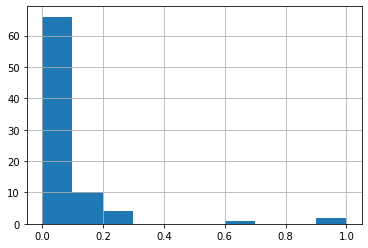

In [643]:
results_both_df['P(dev) for nonvacant sites'].hist()

In [644]:
combined_df = results_df.merge(
    results_geo_df,
    on='City',
    suffixes=[' (by APN)', ' (by geomatching)']
)

In [645]:
combined_df.round(3)

City  Ratio of development on inventory sites (by APN)  \
0       Berkeley                                             0.348   
1         Albany                                             0.634   
2        Alameda                                             0.535   
3      Livermore                                             0.577   
4        Fremont                                             0.876   
..           ...                                               ...   
87     Rio Vista                                             0.102   
88  Monte Sereno                                             1.424   
89    Healdsburg                                             0.511   
90     Fairfield                                             0.320   
91        Sonoma                                             0.182   

    Mean overproduction (by APN)  Inventory housing / all housing (by APN)  \
0                          1.255                                     0.041   
1                            NaN                                     0.000   
2                            NaN                                     0.000   
3                          1.238                                     0.245   
4                          0.438                                     0.112   
..                           ...                                       ...   
87                           NaN                                     0.000   
88                           NaN                                     0.000   
89                         0.279                                     0.028   
90                         0.300                                     0.001   
91                         0.103                                     0.029   

    P(dev) for nonvacant sites (by APN)  P(dev) for vacant sites (by APN)  \
0                                 0.012                             0.025   
1                                 0.000                             0.000   
2                                 0.000                             0.000   
3                                 0.071                             0.165   
4                                 0.028                             0.048   
..                                  ...                               ...   
87                                  NaN                             0.000   
88                                0.000                               NaN   
89                                0.083                             0.083   
90                                0.000                             0.026   
91                                0.000                             0.200   

    P(dev) for inventory (by APN) # nonvacant matches (by APN)  \
0                           0.020                      2 / 167   
1                           0.000                       0 / 33   
2                           0.000                        0 / 7   
3                           0.119                       7 / 99   
4                           0.031                      4 / 141   
..                            ...                          ...   
87                          0.000                        0 / 0   
88                          0.000                        0 / 6   
89                          0.083                       2 / 24   
90                          0.023                        0 / 9   
91                          0.043                       0 / 18   

   # vacant matches (by APN) # matches (by APN)  \
0                    6 / 237            8 / 404   
1                      0 / 8             0 / 41   
2                     0 / 11             0 / 18   
3                   17 / 103           24 / 202   
4                     1 / 21            5 / 162   
..                       ...                ...   
87                    0 / 23             0 / 23   
88                     0 / 0              0 / 6   
89                    3 / 36             5 / 60   
90    

In [646]:
results_df.to_csv('results/apn_matching_results.csv')
results_geo_df.to_csv('results/geo_matching_results.csv')
combined_df.to_csv('results/combined_df.csv')
results_both_df.to_csv('results/apn_or_geo_matching_results.csv')

Let's look into some cities where the APN results and Geo results are very out of line:

In [653]:
large_cities = [city for city, permits in cities_with_permits.items()  if len(permits) > 1000]
combined_df[
    combined_df['City'].isin(large_cities)
]

City  Ratio of development on inventory sites (by APN)  \
4         Fremont                                          0.875979   
5       San Ramon                                          0.440809   
6          Newark                                          0.731663   
7       Brentwood                                          2.510619   
16  San Francisco                                          0.552246   
17         Dublin                                          1.477943   
28         Oakley                                          3.156098   
61         Gilroy                                          2.573668   
66       San Jose                                          0.476356   
72    Morgan Hill                                          1.584496   
79     Santa Rosa                                          1.255446   
82      Vacaville                                          0.308572   
90      Fairfield                                          0.320087   

    Mean overproduction (by APN)  Inventory housing / all housing (by APN)  \
4                       0.437540                                  0.112126   
5                       0.857143                                  0.009278   
6                            NaN                                  0.000835   
7                       2.000000                                  0.000736   
16                      4.676239                                  0.201258   
17                      1.285354                                  0.008646   
28                           NaN                                  0.000000   
61                           NaN                                  0.000000   
66                      1.097829                                  0.296018   
72                      0.065557                                  0.003914   
79                      0.100000                                  0.000526   
82                      2.689655                                  0.047474   
90                      0.300000                                  0.001461   

    P(dev) for nonvacant sites (by APN)  P(dev) for vacant sites (by APN)  \
4                              0.028369                          0.047619   
5                              0.005376                          0.000000   
6                              0.007246                          0.000000   
7                              0.000000                          0.006061   
16                             0.023170                          0.035714   
17                             0.018519                          0.041667   
28                             0.000000                          0.000000   
61                             0.000000                          0.000000   
66                             0.134860                          0.067961   
72                                  NaN                          0.025000   
79                             0.029412                               NaN   
82                             0.000000                          0.014286   
90                             0.000000                          0.025974   

    P(dev) for inventory (by APN) # nonvacant matches (by APN)  \
4                        0.030864                      4 / 141   
5                        0.005263                      1 / 186   
6                        0.007092                      1 / 138   
7                        0.005263                       0 / 25   
16                       0.026307                   107 / 4618   
17                       0.025641                       1 / 54   
28                       0.000000                        0 / 6   
61                       0.000000                       0 / 34   
66                       0.111853                     53 / 393   
72                       0.025000                        0 / 0   
79                       0.029412                       1 / 34   
82                       0.007692                     

<AxesSubplot:xlabel='P(dev) for nonvacant sites (by APN)', ylabel='P(dev) for nonvacant sites (by geomatching)'>

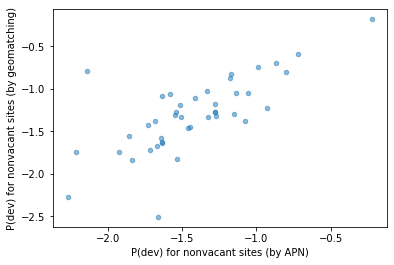

In [660]:
combined_df[[
    'P(dev) for nonvacant sites (by APN)',
    'P(dev) for nonvacant sites (by geomatching)',
]].apply(np.log10).plot.scatter(
    'P(dev) for nonvacant sites (by APN)',
    'P(dev) for nonvacant sites (by geomatching)',
    alpha=0.5,
)

In [654]:
combined_df[
    (combined_df['P(dev) for nonvacant sites (by geomatching)'] / combined_df['P(dev) for nonvacant sites (by APN)']) > 2
]

City  Ratio of development on inventory sites (by APN)  \
2          Alameda                                          0.534967   
6           Newark                                          0.731663   
7        Brentwood                                          2.510619   
20        Danville                                          0.690244   
24      Union City                                          0.432896   
25    Walnut Creek                                          0.992167   
41         Fairfax                                          0.618056   
45        Millbrae                                          0.049230   
52         Belmont                                          0.324803   
60  Portola Valley                                          0.585185   
61          Gilroy                                          2.573668   
69       Palo Alto                                          0.322640   
71       Sunnyvale                                          0.101587   
73        Campbell                                          0.421560   
76      Cloverdale                                          0.205776   
78        Petaluma                                          0.249503   
82       Vacaville                                          0.308572   
85           Dixon                                          0.210740   

    Mean overproduction (by APN)  Inventory housing / all housing (by APN)  \
2                            NaN                                  0.000000   
6                            NaN                                  0.000835   
7                       2.000000                                  0.000736   
20                      1.544002                                  0.547703   
24                           NaN                                  0.000000   
25                           NaN                                  0.000000   
41                      2.000000                                  0.044944   
45                           NaN                                  0.000000   
52                      1.000000                                  0.048485   
60                      1.375000                                  0.139241   
61                           NaN                                  0.000000   
69                      1.000000                                  0.024857   
71                      1.001006                                  0.166566   
73                      4.888889                                  0.093555   
76                      1.304762                                  0.342105   
78                      0.820217                                  0.171786   
82                      2.689655                                  0.047474   
85                      0.118490                                  0.110577   

    P(dev) for nonvacant sites (by APN)  P(dev) for vacant sites (by APN)  \
2                              0.000000                          0.000000   
6                              0.007246                          0.000000   
7                              0.000000                          0.006061   
20                             0.067568                          0.000000   
24                             0.000000                          0.000000   
25                             0.000000                          0.000000   
41                             0.000000                          0.142857   
45                             0.000000                          0.000000   
52                             0.000000                          0.153846   
60                             0.000000                          0.105263   
61                             0.000000                          0.000000   
69                             0.006061                          0.000000   
71                             0.030508                          0.000000   
73                             0.026087                          0.000000   
76     

In [655]:
combined_df[
    (combined_df['P(dev) for nonvacant sites (by geomatching)'] / combined_df['P(dev) for nonvacant sites (by APN)']) < 0.5
]

City  Ratio of development on inventory sites (by APN)  \
31  American Canyon                                          0.658823   
44    Half Moon Bay                                          0.072165   
54            Colma                                          2.884615   
79       Santa Rosa                                          1.255446   

    Mean overproduction (by APN)  Inventory housing / all housing (by APN)  \
31                           NaN                                  0.000000   
44                      0.882745                                  0.342857   
54                      2.538462                                  0.880000   
79                      0.100000                                  0.000526   

    P(dev) for nonvacant sites (by APN)  P(dev) for vacant sites (by APN)  \
31                             0.200000                           0.00000   
44                             0.021739                           0.04893   
54                             1.000000                               NaN   
79                             0.029412                               NaN   

    P(dev) for inventory (by APN) # nonvacant matches (by APN)  \
31                       0.033333                        1 / 5   
44                       0.035439                      7 / 322   
54                       1.000000                        1 / 1   
79                       0.029412                       1 / 34   

   # vacant matches (by APN) # matches (by APN)  \
31                    0 / 25             1 / 30   
44                  16 / 327           23 / 649   
54                     0 / 0              1 / 1   
79                     0 / 0             1 / 34   

    Ratio of development on inventory sites (by geomatching)  \
31                                           0.658823          
44                                           0.072165          
54                                           2.884615          
79                                           1.255446          

    Mean overproduction (by geomatching)  \
31                                   NaN   
44                              0.882745   
54                              2.538462   
79                              0.100000   

    Inventory housing / all housing (by geomatching)  \
31                                          0.000000   
44                                          0.342857   
54                                          0.880000   
79                                          0.000526   

    P(dev) for nonvacant sites (by geomatching)  \
31                                     0.000000   
44                                     0.003106   
54                                     0.000000   
79                                     0.000000   

    P(dev) for vacant sites (by geomatching)  \
31                                  0.000000   
44                                  0.039755   
54                                       NaN   
79                                       NaN   

    P(dev) for inventory (by geomatching)  \
31                               0.000000   
44                               0.021572   
54                               0.000000   
79                               0.000000   

   # nonvacant matches (by geomatching) # vacant matches (by geomatching)  \
31                                0 / 5                            0 / 25   
44                              1 / 322                          13 / 327   
54                                0 / 1                             0 / 0   
79                               0 / 34                             0 / 0   

   # matches (by geomatching)  
31                     0 / 30  
44                   14 / 649  
54                      0 / 1  
79                     0 / 34

In [235]:
import contextily as cx

def plot_city(sites, permits):
    ax = sites.plot(color='blue', edgecolor='red', figsize=(15, 15))
    permits.plot(ax=ax, color='green', markersize=3)
    
#     cx.add_basemap(ax, zoom=18, crs='EPSG:4326')
#     cx.add_basemap(ax, zoom=16, crs='EPSG:4326')
#     cx.add_basemap(
#         ax,
#         source='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png?api_key=c50d11b9-261a-4916-b968-fe8854621c78',
#         zoom=15,
#         crs='EPSG:4326'
#     )
    cx.add_basemap(
        ax,
        source=cx.providers.Stamen.TonerLite,
#         zoom=15,
        crs='EPSG:4326',
    )

In [779]:
reload(map_utils)

<module 'housing_elements.map_utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/map_utils.py'>

In [744]:
city = 'Oakland'
apn_merged_df, geo_merged_df = map_utils.get_match_dfs(cities_with_sites[city], cities_with_permits[city])
matches_df = map_utils.combine_match_dfs(cities_with_sites[city], apn_merged_df, geo_merged_df)

In [745]:
matches_df

index  site_capacity_units  \
0        0                  6.0   
1        1                  NaN   
2        2                 11.0   
3        3                  NaN   
4        4                  NaN   
..     ...                  ...   
340    340                 22.0   
341    341                  NaN   
342    342                 44.0   
343    343                  NaN   
344    344                  NaN   

                                              geometry  apn_matched  \
0    POLYGON ((-122.18724 37.73760, -122.18739 37.7...        False   
1    POLYGON ((-122.26526 37.79845, -122.26503 37.7...        False   
2    POLYGON ((-122.28646 37.81007, -122.28656 37.8...        False   
3    POLYGON ((-122.28645 37.80984, -122.28648 37.8...        False   
4    POLYGON ((-122.28613 37.81000, -122.28616 37.8...        False   
..                                                 ...          ...   
340  POLYGON ((-122.22616 37.77480, -122.22633 37.7...        False   
341  POLYGON ((-122.22576 37.77461, -122.22598 37.7...        False   
342  POLYGON ((-122.17295 37.74684, -122.17265 37.7...        False   
343  POLYGON ((-122.17249 37.74676, -122.17279 37.7...        False   
344  POLYGON ((-122.17279 37.74662, -122.17271 37.7...        False   

     geo_matched match_results  
0          False            []  
1          False            []  
2          False            []  
3          False            []  
4          False            []  
..           ...           ...  
340        False            []  
341        False            []  
342        False            []  
343        False            []  
344        False            []  

[345 rows x 6 columns]

In [748]:
matches_df.dropna(subset=['site_capacity_units'])

index  site_capacity_units  \
0        0                  6.0   
2        2                 11.0   
8        8                 56.0   
11      11                137.0   
14      14                 11.0   
..     ...                  ...   
335    335                 59.0   
338    338                  3.0   
339    339                 45.0   
340    340                 22.0   
342    342                 44.0   

                                              geometry  apn_matched  \
0    POLYGON ((-122.18724 37.73760, -122.18739 37.7...        False   
2    POLYGON ((-122.28646 37.81007, -122.28656 37.8...        False   
8    POLYGON ((-122.27539 37.80329, -122.27546 37.8...        False   
11   POLYGON ((-122.26892 37.81019, -122.26900 37.8...        False   
14   POLYGON ((-122.28769 37.81035, -122.28779 37.8...        False   
..                                                 ...          ...   
335  POLYGON ((-122.21791 37.78077, -122.21824 37.7...        False   
338  POLYGON ((-122.22645 37.78433, -122.22659 37.7...        False   
339  POLYGON ((-122.22684 37.77889, -122.22668 37.7...        False   
340  POLYGON ((-122.22616 37.77480, -122.22633 37.7...        False   
342  POLYGON ((-122.17295 37.74684, -122.17265 37.7...        False   

     geo_matched match_results  
0          False            []  
2          False            []  
8          False            []  
11         False            []  
14         False            []  
..           ...           ...  
335        False            []  
338        False            []  
339        False            []  
340        False            []  
342        False            []  

[197 rows x 6 columns]

In [662]:
combined_df[
    combined_df['City'].isin(['Clayton', 'Dublin', 'Gilroy', 'Morgan Hill'])
]

City  Ratio of development on inventory sites (by APN)  \
14      Clayton                                          0.038168   
17       Dublin                                          1.477943   
61       Gilroy                                          2.573668   
72  Morgan Hill                                          1.584496   

    Mean overproduction (by APN)  Inventory housing / all housing (by APN)  \
14                      0.022727                                  0.100000   
17                      1.285354                                  0.008646   
61                           NaN                                  0.000000   
72                      0.065557                                  0.003914   

    P(dev) for nonvacant sites (by APN)  P(dev) for vacant sites (by APN)  \
14                             0.066667                          0.000000   
17                             0.018519                          0.041667   
61                             0.000000                          0.000000   
72                                  NaN                          0.025000   

    P(dev) for inventory (by APN) # nonvacant matches (by APN)  \
14                       0.043478                       1 / 15   
17                       0.025641                       1 / 54   
61                       0.000000                       0 / 34   
72                       0.025000                        0 / 0   

   # vacant matches (by APN) # matches (by APN)  \
14                     0 / 8             1 / 23   
17                    1 / 24             2 / 78   
61                     0 / 5             0 / 39   
72                    2 / 80             2 / 80   

    Ratio of development on inventory sites (by geomatching)  \
14                                           0.038168          
17                                           1.477943          
61                                           2.573668          
72                                           1.584496          

    Mean overproduction (by geomatching)  \
14                              0.022727   
17                              1.285354   
61                                   NaN   
72                              0.065557   

    Inventory housing / all housing (by geomatching)  \
14                                          0.100000   
17                                          0.008646   
61                                          0.000000   
72                                          0.003914   

    P(dev) for nonvacant sites (by geomatching)  \
14                                     0.133333   
17                                     0.037037   
61                                     0.205882   
72                                          NaN   

    P(dev) for vacant sites (by geomatching)  \
14                                     0.000   
17                                     0.000   
61                                     0.000   
72                                     0.175   

    P(dev) for inventory (by geomatching)  \
14                               0.086957   
17                               0.025641   
61                               0.179487   
72                               0.175000   

   # nonvacant matches (by geomatching) # vacant matches (by geomatching)  \
14                               2 / 15                             0 / 8   
17                               2 / 54                            0 / 24   
61                               7 / 34                             0 / 5   
72                                0 / 0                           14 / 80   

   # matches (by geomatching)  
14                     2 / 23  
17                     2 / 78  
61                     7 / 39  
72                    14 / 80

In [683]:
reload(utils)
city = 'Dublin'
map_utils.plot_city_interactive(cities_with_sites[city], cities_with_permits[city])

In [664]:
cities_with_sites['Dublin']

objectid           apn        locapn  \
21742     63876  941021003200  941021003200   
21743     63877  941021003100  941021003100   
21744     63878  941021001602  941021001602   
21745     63879  941021001500  941021001500   
21746     63880  941021001400  941021001400   
...         ...           ...           ...   
23020     65154  941021000202  941021000202   
23021     65155  941021000504  941021000504   
23022     65156  941021000505  941021000505   
23024     65158  941021000503  941021000503   
23025     65159  941021000600  941021000600   

                                                 genplan           zoning  \
21742  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   
21743  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   
21744  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   
21745  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   
21746  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   
...                                                  ...              ...   
23020  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   
23021  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   
23022  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   
23024  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   
23025  Downtown Dublin Specific Plan - Village Parkwa...  Village Parkway   

       gacres  locacres  currunits  allowden  allowhigh  ...  siteconst  \
21742   0.441      0.46          0       NaN          0  ...        NaN   
21743   0.541      0.53          0       NaN          0  ...        NaN   
21744   1.039      1.02          0       NaN          0  ...        NaN   
21745   0.984      1.05          0       NaN          0  ...        NaN   
21746   1.137      1.05          0       NaN          0  ...        NaN   
...       ...       ...        ...       ...        ...  ...        ...   
23020   1.043      0.99          0       NaN          0  ...        NaN   
23021   1.947      2.01          0       NaN          0  ...        NaN   
23022   0.709      0.73          0       NaN          0  ...        NaN   
23024   0.593      0.56          0       NaN          0  ...        NaN   
23025   1.117      1.10          0       NaN          0  ...        NaN   

            sitetype  pdaparcel bundled                         existuse  \
21742  Underutilized          Y     NaN                          Speedee   
21743  Underutilized          Y     NaN                          Corwood   
21744  Underutilized          Y     NaN                              NaN   
21745  Underutilized          Y     NaN                    Village Green   
21746  Underutilized          Y     NaN  Vacant/Rahma Market & Taco Bell   
...              ...        ...     ...                              ...   
23020  Underutilized          Y     NaN             Parkway Center, por.   
23021  Underutilized          Y     NaN             Parkway Center, por.   
23022  Underutilized          Y     NaN             Parkway Center, por.   
23024  Underutilized          Y     NaN             Parkway Center, por.   
23025  Underutilized          Y     NaN                              NaN   

      localnote    Shape__Are Shape__Len  \
21742       NaN  1.826397e-07   0.002063   
21743       NaN  2.237534e-07   0.002143   
21744       NaN  4.297522e-07   0.002721   
21745       NaN  4.069398e-07   0.002652   
21746       NaN  4.705294e-07   0.002809   
...         ...           ...        ...   
23020       NaN  4.313538e-07   0.002942   
23021       NaN  8.053985e-07   0.003865   
23022       NaN  2.932666e-07   0.002226   
23024       NaN  2.454772e-07   0.002031   
23025       NaN  4.621529e-07   0.002999   

                                                geometry index  
21742  POLYGON ((-121.92424 37.70821, -121.92422 37.7...     0  
21743  POLYGON ((-121.92441 37.70843, -121.9

In [675]:
cities_with_permits['Dublin'][['permyear', 'apn', 'totalunit']]

permyear        apn  totalunit
0         2017       <NA>          1
1         2017       <NA>          1
2         2017       <NA>          1
3         2017       <NA>          1
4         2017       <NA>          1
...        ...        ...        ...
2871      2019  985127002          1
2872      2019  985127002          1
2873      2019  985127002          1
2874      2019  985127002          1
2875      2019  985127002          1

[2876 rows x 3 columns]

In [666]:
cities_with_sites['Dublin']['apn'].isnull().mean()

0.0

In [676]:
reload(utils)
city = 'Dublin'
plot_city_interactive(cities_with_sites[city], cities_with_permits[city])

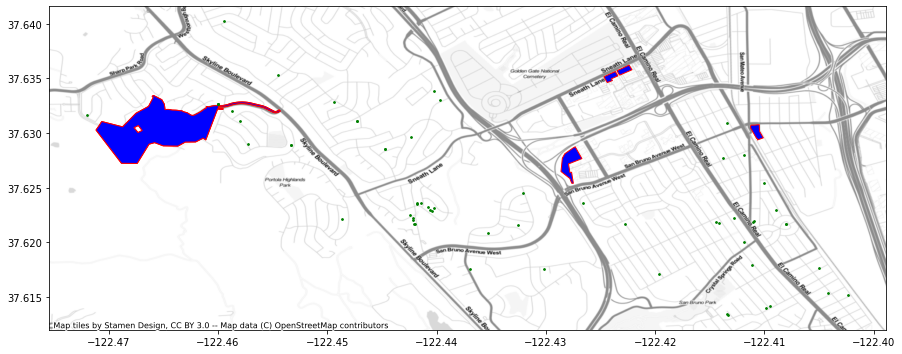

In [236]:
plot_city(cities_with_sites['San Bruno'], cities_with_permits['San Bruno'])

In [227]:
sites = cities_with_sites['Windsor']
permits = cities_with_permits['Windsor']

In [242]:
sites.columns

Index(['objectid', 'apn', 'locapn', 'genplan', 'zoning', 'gacres', 'locacres',
       'allowden', 'allowlow', 'allowhigh', 'relcapcty', 'desafford', 'aff_vl',
       'aff_l', 'aff_m', 'aff_am', 'num_m', 'num_am', 'infcapcty', 'siteconst',
       'sitetype', 'pdaparcel', 'bundled', 'existuse', 'localnote',
       'Shape__Are', 'Shape__Len', 'geometry', 'index'],
      dtype='object')

In [246]:
sites[['apn', 'locapn', 'relcapcty', 'gacres', 'zoning', 'locacres', 'allowden']]

apn     locapn  relcapcty  gacres                      zoning  \
40150  164530005  164530005        NaN   0.014                         NaN   
40161  164520012  164520012        NaN   0.027                         NaN   
40162  164520013  164520013        NaN   0.027                         NaN   
40163  164520014  164520014        NaN   0.028                         NaN   
40164  164520015  164520015        NaN   0.025                         NaN   
40165  164530001  164530001        NaN   0.015                         NaN   
40166  164530002  164530002        NaN   0.016                         NaN   
40167  164530003  164530003        NaN   0.017                         NaN   
40168  164530004  164530004        NaN   0.015                         NaN   
40169  164530006  164530006        NaN   0.021                         NaN   
40170  164530007  164530007        NaN   0.020                         NaN   
40171  164530008  164530008        NaN   0.021                         NaN   
40172  164530009  164530009        NaN   0.021                         NaN   
40173  164530010  164530010        NaN   0.021                         NaN   
41908  163080047  163080047       25.0   5.024     Surrounding Residential   
41909   66100068   66100068       33.0   0.867                 Town Center   
41910  164020045  164020045       46.0   7.646  Medium Density Residential   
41911  163011036  163011036       88.0   4.413                      SR, VR   
41912  163012027  163012027        NaN   1.838                         NaN   
41913  163012028  163012028        NaN   2.591                         NaN   
41914  163012029  163012029        NaN   1.395                         NaN   
41915  163012031  163012031        NaN   4.097                         NaN   
41974  164520009  164520009        NaN   0.028                         NaN   
42000  164520010  164520010        NaN   0.028                         NaN   
42001  164520011  164520011        NaN   0.027                         NaN   
42007  164520001  164520001        NaN   0.027                         NaN   
42008  164520002  164520002        NaN   0.027                         NaN   
42009  164520003  164520003        NaN   0.027                         NaN   
42010  164520004  164520004        NaN   0.025                         NaN   
42011  164520005  164520005        NaN   0.029                         NaN   
42012  164520006  164520006        NaN   0.027                         NaN   
42013  164520007  164520007        NaN   0.027                         NaN   
42014  164520008  164520008        NaN   0.027                         NaN   
42015  161070036  161070036      387.0  27.162         Compact Residential   
42016   66170013   66170013      360.0   2.182         Compact Residential   
42017   66170033   66170033        NaN   2.446                         NaN   
42018  164020005  164020005        NaN   1.086                         NaN   
42019  164020006  164020006        NaN   0.892                         NaN   
42020  164020007  164020007        NaN   0.289                         NaN   
42021  164020008  164020008        NaN   2.065                         NaN   
42022  164020041  164020041        NaN  10.875                         NaN   
42023  163130030  163130030       80.0   6.762    High Density Residential   
42024  163130031  163130031        NaN   5.011                         NaN   
42026  162020004   16202004       87.0  17.624     Surrounding Residential   
42027  161060036  161060036       80.0   0.910         Compact Residential   
42028  161060038  161060038        NaN   1.028                         NaN   
42029   66100002   66100002        NaN   0.981                         NaN   
42030   66100003   66100003        NaN   0.970                         NaN   
42031   66060004   66060004       51.0   3.643  Medium Density Residential   
42032   66060007   66060007        NaN   3.509                         NaN   
42033   66060021   66060021        

In [228]:
permits[
    permits.apn.isin(
        sites.apn
    )
][['permyear', 'address', 'totalunit', 'apn']]

permyear          address  totalunit          apn
22      2015  126 Johnson St.          1  164530004.0
23      2015  128 Johnson St.          1  164530005.0
24      2015  124 Johnson St.          1  164530003.0
25      2015  122 Johnson St.          1  164530002.0
26      2015  120 Johnson St.          1  164530001.0

In [234]:
permits[['permyear', 'address', 'totalunit']]

permyear               address  totalunit
0       2017        222 Johnson St          1
1       2017  6087 Old Redwood Hwy         36
2       2017          112 Carey Ct          1
3       2017        9757A Dawn Way          1
4       2016         10341 Herb Rd          1
..       ...                   ...        ...
68      2019    915 Starr Creek Ct          1
69      2019         8770 Starr Rd          1
70      2019         411 Harper Ct          1
71      2019         9821 Dawn Way          1
72      2019      113 Pleasant Ave          1

[73 rows x 3 columns]

In [229]:
sites.columns

Index(['objectid', 'apn', 'locapn', 'genplan', 'zoning', 'gacres', 'locacres',
       'allowden', 'allowlow', 'allowhigh', 'relcapcty', 'desafford', 'aff_vl',
       'aff_l', 'aff_m', 'aff_am', 'num_m', 'num_am', 'infcapcty', 'siteconst',
       'sitetype', 'pdaparcel', 'bundled', 'existuse', 'localnote',
       'Shape__Are', 'Shape__Len', 'geometry', 'index'],
      dtype='object')

In [230]:
sites[
    sites['apn'] == 17080150.0
][['apn', 'locapn', 'relcapcty', 'gacres', 'locacres', 'localnote', 'index', 'existuse', 'sitetype', 'zoning']]

Empty DataFrame
Columns: [apn, locapn, relcapcty, gacres, locacres, localnote, index, existuse, sitetype, zoning]
Index: []

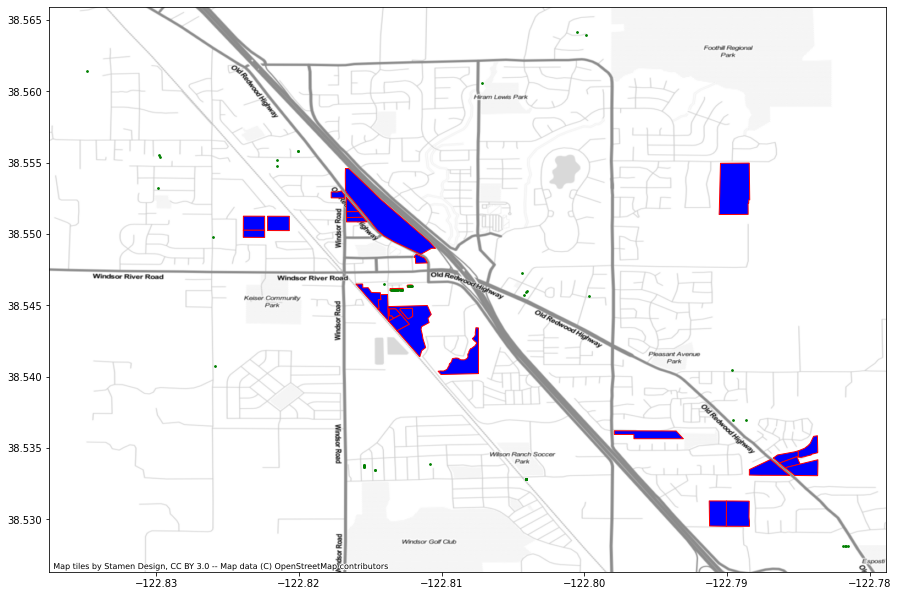

In [237]:
plot_city(cities_with_sites['Windsor'], cities_with_permits['Windsor'])

In [137]:
cities_with_permits['San Bruno'].columns

Index(['objectid', 'joinid', 'permyear', 'county', 'jurisdictn', 'apn',
       'address', 'zip', 'projname', 'hcategory', 'vlowdr', 'vlowndr',
       'vlowtot', 'lowdr', 'lowndr', 'lowtot', 'moddr', 'modndr', 'modtot',
       'amodtot', 'totalunit', 'tenure', 'mapped', 'mapnotes', 'pda',
       'pdacycle', 'pdajoinid', 'tpa', 'tpacycle', 'hsngsite', 'rhnacycle',
       'notes', 'ObjectId2', 'OBJECTID', 'geometry', 'Prior APN+',
       'Local Jurisdiction Tracking ID+', 'Building Permits Date Issued',
       'How many of the units were Extremely Low Income?+',
       'Was Project APPROVED using GC 65913.4(b)? (SB 35 Streamlining) Y/N',
       'Infill Units? Y/N+', 'Deed Restriction Type (see instructions)',
       'For units affordable without financial assistance or deed restrictions, explain how the locality determined the units were affordable (see instructions)',
       'Term of Affordability or Deed Restriction (years) (if affordable in perpetuity enter 1000)+',
       'Number of D

In [45]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:k
    print(column, (combined_df[column + ' (by geomatching)'] >= combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.845360824742268
P(dev) for vacant sites 0.7938144329896907
P(dev) for inventory 0.8969072164948454


In [46]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] == combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.27835051546391754
P(dev) for vacant sites 0.25773195876288657
P(dev) for inventory 0.17525773195876287


# "Ground truth" data

In [667]:
def get_ground_truth_results_for_city(city: str) -> pd.DataFrame:
    if city == 'San Jose':
        permits = san_jose_permits.load_all_permits()
    elif city == 'San Francisco':
        permits = san_francisco_permits.load_all_permits()
    elif city == 'Los Altos':
        permits = los_altos_permits.load_all_permits()
    else:
        raise ValueError(f"Ground truth data not available for {city}")
        
    permits = utils.load_all_new_building_permits(city)
    sites = utils.load_site_inventory(city)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': utils.calculate_pdev_for_nonvacant_sites(sites, permits),
        'P(dev) for vacant sites': utils.calculate_pdev_for_vacant_sites(sites, permits),
        'P(dev) for inventory': utils.calculate_pdev_for_inventory(sites, permits),
    }

In [672]:

permits = pd.read_csv("./data/raw_data/sf_permits.csv")
print(permits.columns)
date_cols = [c for c in permits.columns if 'Date' in c]
permits[date_cols] = permits[date_cols].apply(pd.to_datetime)

Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


In [673]:
print(permits.columns)

Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


In [685]:
%%time
ground_truth_cities = ['Los Altos', 'San Francisco']
ground_truth_results_df = pd.DataFrame([get_ground_truth_results_for_city(city) for city in ground_truth_cities])

Dropping constant columns: ['county', 'num_vl', 'rhnayrs', 'rhnacyc', 'infcapcty', 'allowlow', 'jurisdict', 'num_m', 'num_am', 'num_l']
DF shape (57, 25)
Total units permitted: 532
Total realistic capacity in inventory: 257.5
Number of inventory sites developed: 9
Number of units permitted on inventory sites: 34
Total realistic capacity of inventory sites: 38.0
Units permitted on inventory sites: 34
Total units permitted: 532
Index(['version https://git-lfs.github.com/spec/v1'], dtype='object')


KeyError: 'Block'

In [684]:
ground_truth_results_df

City  Ratio of development on inventory sites  Mean overproduction  \
0  Los Altos                                 2.066019            -0.444444   

   Inventory housing / all housing  P(dev) for nonvacant sites  \
0                          0.06391                    0.088235   

   P(dev) for vacant sites  P(dev) for inventory  
0                  0.26087              0.157895